In [546]:
import pandas as pd
import numpy as np
import os,fnmatch
import xarray as xr
import matplotlib.pylab as plt
from matplotlib import rcParams
from functools import reduce
import h5py
from dask import array as da
import seaborn as sns
sns.set()
import scipy.optimize as optimize
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (18, 12),
         'axes.labelsize': 28,
         'axes.titlesize':28,
         'xtick.labelsize':28,
         'ytick.labelsize':28,
         'axes.labelweight':'bold',
          'legend.fontsize': 28}
         
plt.rcParams.update(params)


In [2]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [966]:
# Loding the basline
bl_len = pd.read_csv('/data/isaac/DR1/meerkatbaselinelengh.csv')
bl_len = bl_len.iloc[:,1:].values[0]
# Baseline index sorted by ascending order
indx = np.argsort(bl_len)
bl_len = bl_len[indx]

# Chose band that you interested in
### Full band := 1
### Clean band upper (1.3 - 1.5 GHz) := 2
### Clean band lower (970 - 1080 MHz) :=3
### Clean band both upper and lower       := 4
### Clean band both upper and lower less than 1000m := 5

In [1446]:
band = int(input('if clean and press one or if all band press two :'))
if band == 1:
    dr1 =np.load('/data/isaac/DR1/montl_mean__per_bl.npy')
    dr0= np.load('/data/isaac/DR0/montly_per_bl_mean.py.npy')
if band==2:
    dr0 = np.load('/data/isaac/DR0/clean_upper_band_DR0.npy')
    dr1 = np.load('/data/isaac/DR1/clean_upper_band_DR1.npy')
if band==3:
    dr0 = np.load('/data/isaac/DR0/clean_lower_band_DR0.npy')
    dr1 = np.load('/data/isaac/DR1/clean_lower_band_DR1.npy')
if band==4:
    dr0 = np.load('/data/isaac/DR0/clean_full_band_DR0.npy')
    dr1 = np.load('/data/isaac/DR1/clean_full_band_DR1.npy')
    
if band==5:
    dr0 = np.load('/data/isaac/DR0/clean_full_band_bl_less_1000_DR0.npy')
    dr1 = np.load('/data/isaac/DR1/clean_full_band_bl_less1000_DR1.npy')
    
if band ==6:
    dr0 = np.load('/data/isaac/DR0/clean_full_band_DR0+file_name.npy')
    dr1= np.load('/data/isaac/DR1/clean_full_band_DR1+file_name.npy')
    

if clean and press one or if all band press two :1


In [1548]:
def data_to_use(dr0,dr1,d0=False,d1=False,both=False):
    '''
    Input : dr0,dr1 mean per baseline
    
    Returns : List  := len(list) gives the total number of files used
                    := list[i][0] gives the probability of RFI as function of basline for obs i
                    := list[i][1] gives the length of the observation in seconds for obs i
                    := list[i][2] gives the date of obs i
    '''
    Data = []
    data1 = []
    for i in range(len(dr1)):
        #Data.append([dr1[i][0],dr1[i][3],dr1[i][2][0:4]+dr1[i][2][5:7]+'05',dr1[i][4][35:45]])
        Data.append([dr1[i][0],dr1[i][3],dr1[i][2][0:4]+dr1[i][2][5:7]+'05'])
        #data1.append([dr1[i][0],dr1[i][3],dr1[i][2][0:4]+dr1[i][2][5:7]+'05',dr1[i][4][35:45]])
        data1.append([dr1[i][0],dr1[i][3],dr1[i][2][0:4]+dr1[i][2][5:7]+'05'])
        
    for i in range(len(dr0)):
        #Data.append([dr0[i][0],dr0[i][1],dr0[i][2],dr0[i][3][32:42]])
        Data.append([dr0[i][0],dr0[i][1],dr0[i][2]])
    if d0:
        return dr0
    if d1:
        return data1
    if both:
        return Data

In [1549]:
Data = data_to_use(dr0,dr1,both=True,d1=False,d0=False)

In [1550]:
len(Data)

337

In [1560]:
#Data =pd.read_csv('/data/isaac/DR1/DR1_Full_band_RFI_Pr_Data.csv')
Data = pd.read_csv('/data/isaac/DR1/DR1_clean_band_RFI_Pr_Data.csv')

In [1561]:
len(Data)

396

In [906]:
bl_len = pd.read_csv('/home/isihlangu/baseline_length.csv')

In [1453]:
#dr0data = pd.read_csv('/data/isaac/DR0/infoDR0.csv')
#dr1data = pd.read_csv('/data/isaac/DR1/resultsdr1/All_2018_imaging_observations.csv')

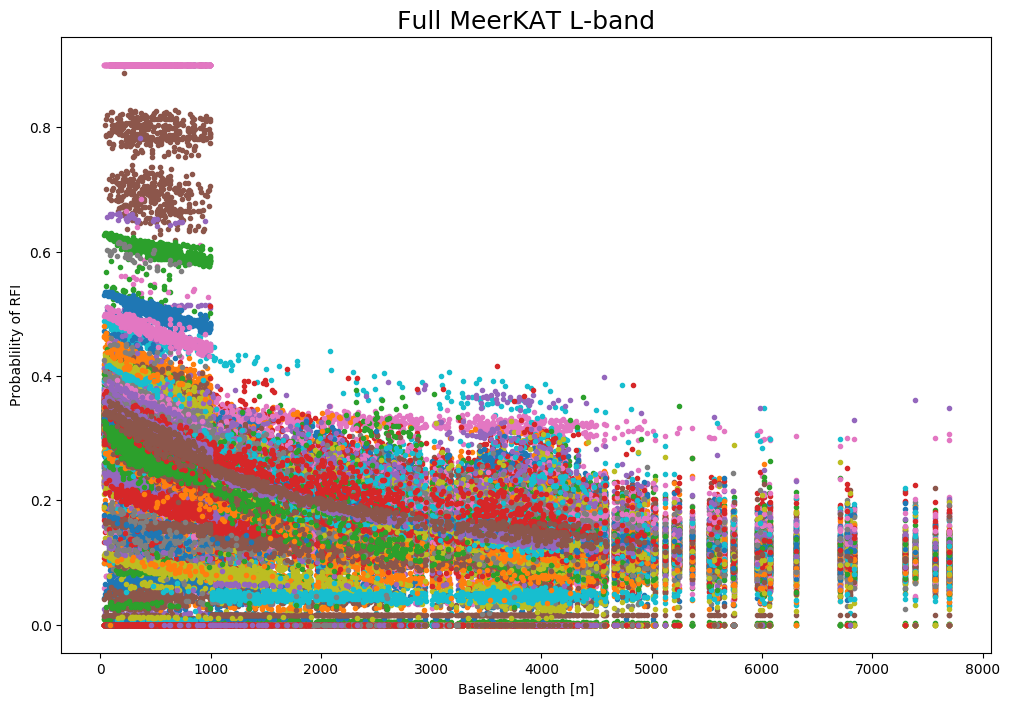

In [1454]:
plt.figure(figsize=(12,8))
for i in range(len(Data)):
    plt.plot(bl_len,Data.iloc[i].values[0:2016],'.')
    fll = str(int(Data.iloc[i]['RDBFile']))
plt.title('Full MeerKAT L-band',fontsize =18)
plt.xlabel('Baseline length [m]')
plt.ylabel('Probablility of RFI')
plt.show()

## Computing the 68% confidence interval

In [955]:
FileName1 = '/data/isaac/DR0/verification/verifDR0.zarr'
FileName2 = '/data/isaac/DR1/verification/verifDR1.zarr'
# Loading the data
MyData1 = xr.open_zarr(FileName1)
MyData2 = xr.open_zarr(FileName2)
# Combining two dataset
data = MyData1+MyData2
# Extracting the Master and the Counter array
MyMaster = data.master.astype(float)
MyCounter =data.counter.astype(float)

In [956]:
MyMeanTimeMaster = MyMaster.sum(dim = ['frequency','time','elevation','azimuth']) 
MyMeanTimeCounter = MyCounter.sum(dim = ['frequency','time','elevation','azimuth'])
MyMeanTimeProb = MyMeanTimeMaster.astype(float)/MyMeanTimeCounter.astype(float)
MyMeanTimeProb = MyMeanTimeProb.persist()

In [1430]:
arr = []
dim = ['baseline']
for dimension in dim:
    if dimension =='baseline':
        t0 = np.load('/data/isaac/DR0/one_D_Arrays/Baseline_mean_R0.npy')
        t1 = np.load('/data/isaac/DR1/one_D_Arrays/Baseline_DR1_ave.npy')
        t1_del = np.delete(t1,24,0)
        t1_del = t1_del.tolist()
        # Combine dr0 and dr1 dataset
        for i in range(t0.shape[0]):
            t1_del.append(t0[i,:])
        arr.append(np.array(t1_del))

In [1433]:
arr[0].shape

(412, 2016)

In [1434]:
# Computing the 68-Percentile
def err(arr,conf):
    arr = np.array(arr)
    lower = (100-conf)/2.0
    upper = 100 - lower
    l = np.zeros(arr.shape[1])
    u = np.zeros(arr.shape[1])
   
    for i in range(arr.shape[1]):
        idx = np.where(~np.isnan(arr[:,i])&(arr[:,i]!=0))[0]
        if np.sum(idx)==0:
             data = np.sort(arr[:,i])
        else:
            data = np.sort(arr[:,i][idx])
        l[i] = np.percentile(data,lower)
        u[i] =  np.percentile(data,upper)
    return l,u

In [1435]:
er68 =  err(arr[0],conf=68)

## Fitting the power law

In [1128]:
from scipy.optimize import curve_fit

In [1129]:
def func_powerlaw(x,c0,c,a):
    return c0 + (x**a)*c

In [1130]:
x = bl_len
y = MyMeanTimeProb[indx]
sol2 = curve_fit(func_powerlaw, x, y, p0 = np.asarray([0.4,-0.8,2]))
c0 = sol2[0][0]
c = sol2[0][1]
a = sol2[0][2]

/home/isihlangu/hprfi/local/lib/python3.5/site-packages/xarray/core/indexing.py:1195: PerformanceWarning: Slicing with an out-of-order index is generating 204 times more chunks
  return self.array[key]


In [1131]:
xx=np.linspace(0,8000,2016)
yy = func_powerlaw(xx,c0,c,a)

In [1132]:
less100 = np.where(bl_len<=1000)[0]

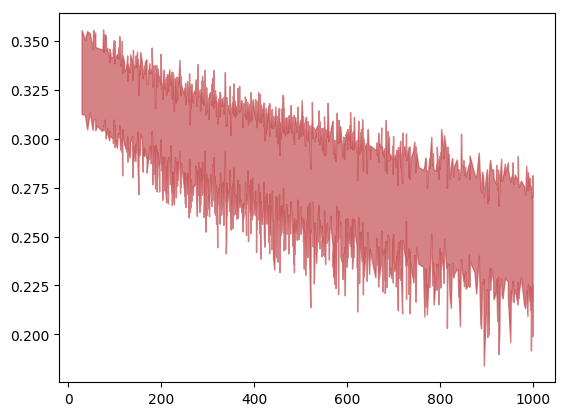

In [1133]:
plt.fill_between(bl_len[less100], er68[0][indx][less100], er68[1][indx][less100],
                 color='r', alpha=0.7,label='68% Confidence Interval')
#plt.plot(bl_len,MyMeanTimeProb[indx],'.')
#plt.plot(xx, yy)

In [1478]:
above68 = []
flnames1 = []
flnames0 = []
fls = []
gd = []
for fl in range(len(Data)):
    bl_data = Data.iloc[fl].values[less100]
    if len(np.where(bl_data>er68[1][indx][less100])[0])>0:
        #above68.append(str(int(Data.iloc[fl]['RDBFile'])))
        fll = str(int(Data.iloc[fl]['RDBFile']))
        flnames1.append('http://archive-gw-1.kat.ac.za:7480/'+fll+'/'+fll+'_sdp_l0.rdb')
        flnames0.append(fll+'_sdp_l0')
        fls.append(str(int(Data.iloc[fl]['RDBFile']))+'_sdp_l0.rdb')
    else:
    
        #plt.plot(bl_len,Data.iloc[fl].values[0:2016],'.')
        gd.append(str(int(Data.iloc[fl]['RDBFile']))+'_sdp_l0.rdb')
        #plt.show()     

/home/isihlangu/hprfi/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [1135]:
df0 =  dr0data[dr0data.Filename.isin(flnames0)]
df1 = dr1data[dr1data.LiteLink.isin(flnames1)]

In [1362]:
#Data_high_prob = Data[Data.RDBFile.isin(gd)]
Data_high_prob = Data[Data.RDBFile.isin(fls)]

In [1397]:
len(fls)+len(gd)

336

### Remove all the files with observation length less than 15 minutes

In [1138]:
s = Data['ObsLen']>900

In [1139]:
New_Data = Data[s]

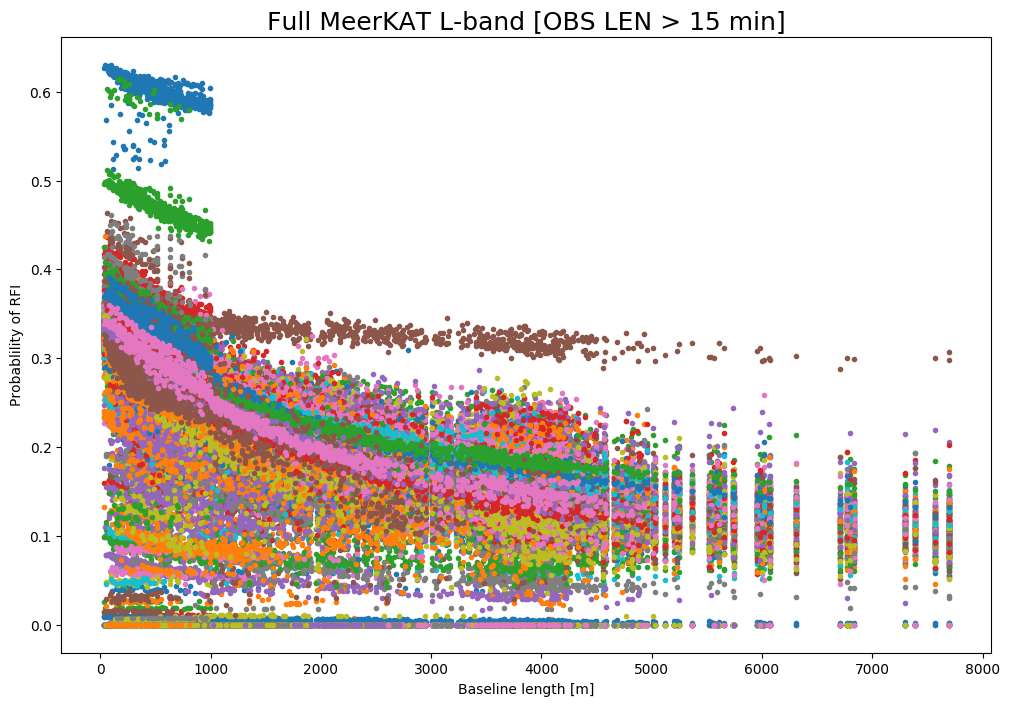

In [1140]:
plt.figure(figsize=(12,8))
for i in range(len(New_Data)):
    plt.plot(bl_len,New_Data.iloc[i].values[0:2016],'.')
    fll = str(int(New_Data.iloc[i]['RDBFile']))
plt.title('Full MeerKAT L-band [OBS LEN > 15 min]',fontsize =18)
plt.xlabel('Baseline length [m]')
plt.ylabel('Probablility of RFI')
plt.show()

### Getting all the files with probabality greater that 40%

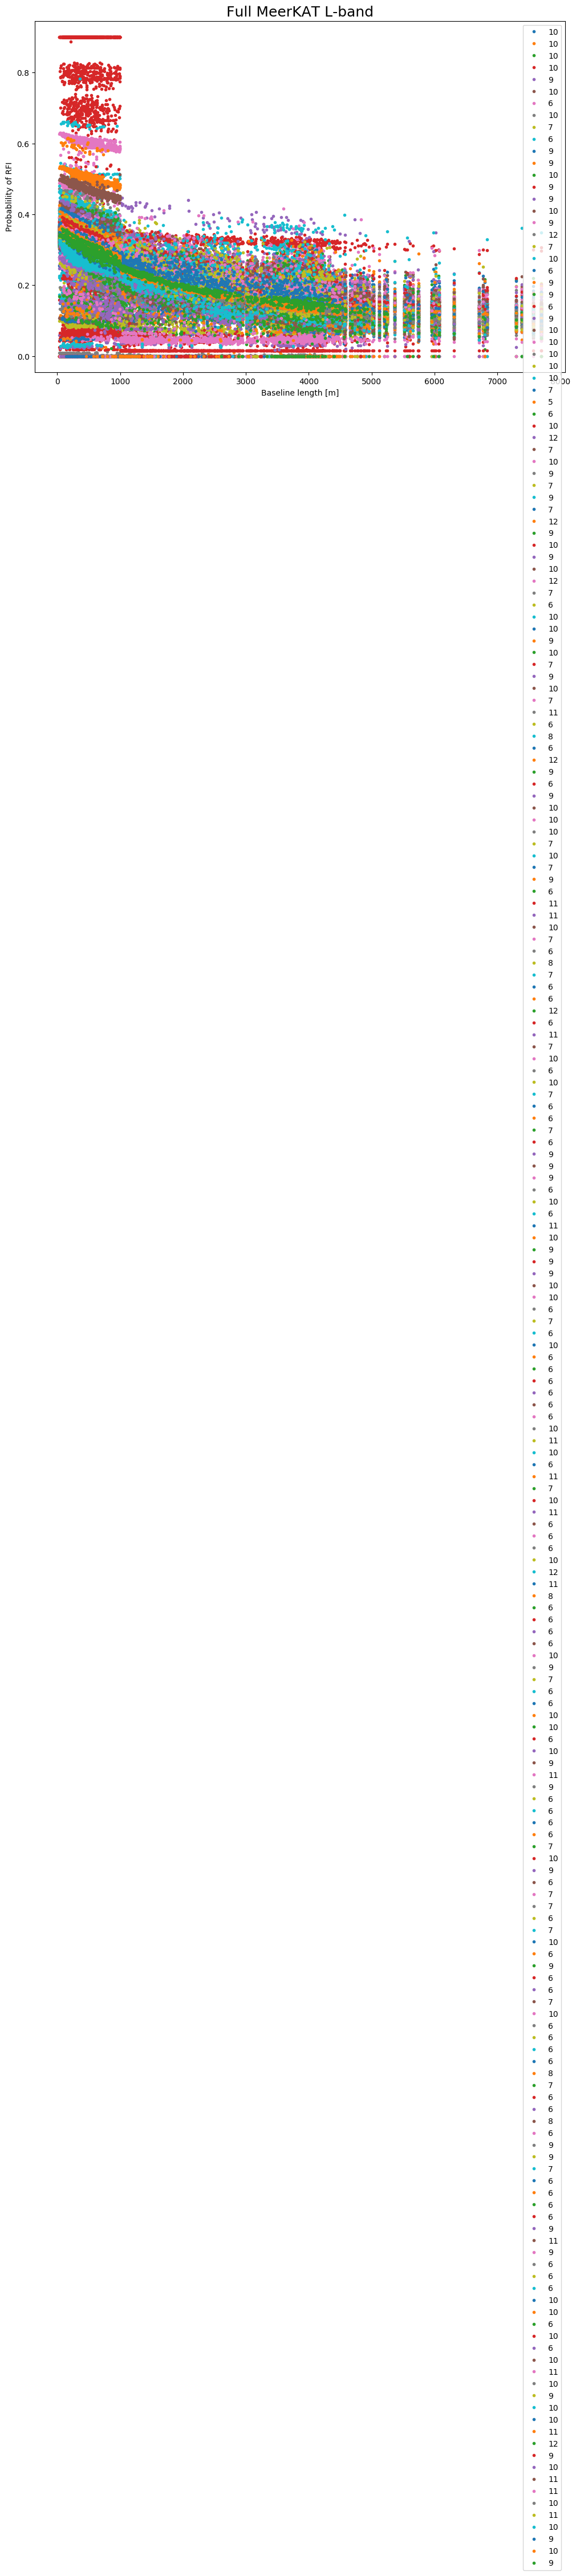

In [1167]:
plt.figure(figsize=(12,8))
for i in range(len(Data_high_prob)):
    plt.plot(bl_len,Data_high_prob.iloc[i].values[0:2016],'.',label=str(Data_high_prob['Months'].iloc[i]))
    fll = str(int(Data_high_prob.iloc[i]['RDBFile']))
plt.title('Full MeerKAT L-band',fontsize =18)
plt.xlabel('Baseline length [m]')
plt.ylabel('Probablility of RFI')
plt.legend()
plt.show()

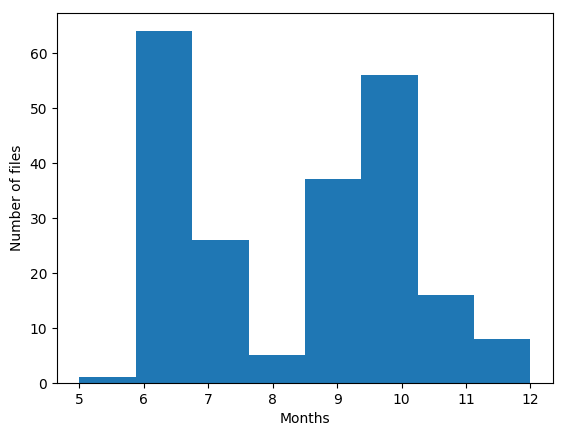

In [1171]:
Data_high_prob['Months'].plot.hist(bins=8)
plt.xlabel('Months')
plt.ylabel('Number of files')
plt.show()

In [1324]:
FullDR1 = pd.read_csv('/data/isaac/FullDR1.csv')

In [1337]:
FullDR1['DateStamp'] = pd.to_datetime(FullDR1.DateStamp)
FullDR1['DateStamp'] = pd.to_datetime(FullDR1 ['DateStamp'].dt.strftime('%Y%m%d'))
FullDR1 .set_index('DateStamp', inplace=True)

In [1359]:
# Keys
#FullDR1.groupby(pd.Grouper(freq='M')).groups.keys()

In [1377]:
#FullDR1.groupby(pd.Grouper(freq='M')).get_group('2018-06-30 00:00:00').resample('W').count()

In [1369]:
#FullDR1.groupby(pd.Grouper(freq='M')).get_group('2018-06-30 00:00:00').resample('W').get_group('2018-06-10')

In [1476]:
Bad_data = FullDR1[FullDR1.Filename.isin(fls)]

In [1477]:
Bad_data.to_csv('Outside_68%_confidence.csv',index=False)

In [1415]:
# Keys
Bad_data.groupby(pd.Grouper(freq='M')).groups.keys()

dict_keys([Timestamp('2018-05-31 00:00:00', freq='M'), Timestamp('2018-08-31 00:00:00', freq='M'), Timestamp('2018-03-31 00:00:00', freq='M'), Timestamp('2018-06-30 00:00:00', freq='M'), Timestamp('2018-07-31 00:00:00', freq='M'), Timestamp('2018-04-30 00:00:00', freq='M'), Timestamp('2018-10-31 00:00:00', freq='M'), Timestamp('2018-11-30 00:00:00', freq='M'), Timestamp('2018-12-31 00:00:00', freq='M'), Timestamp('2018-09-30 00:00:00', freq='M')])

In [1470]:
Bad_data.groupby(pd.Grouper(freq='M')).get_group('2018-11-30 00:00:00').resample('W').get_group('2018-11-18')

,DataType,Filename,obs_len
DateStamp,,,
2018-11-12,DR0,1542004109_sdp_l0.rdb,1591.326777
2018-11-12,DR0,1541988019_sdp_l0.rdb,47.979702
2018-11-12,DR0,1542011232_sdp_l0.rdb,495.790252
2018-11-12,DR0,1542008472_sdp_l0.rdb,55.976319
2018-11-12,DR0,1542009613_sdp_l0.rdb,135.942489


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

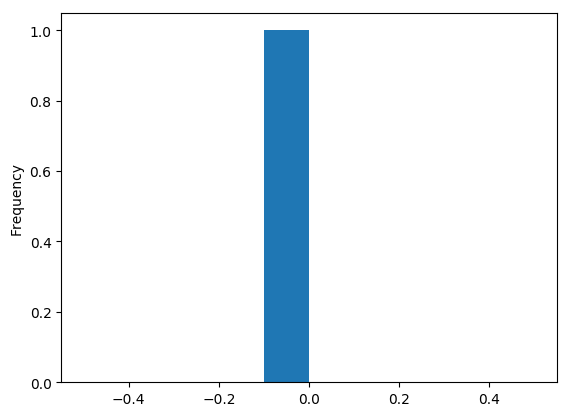

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

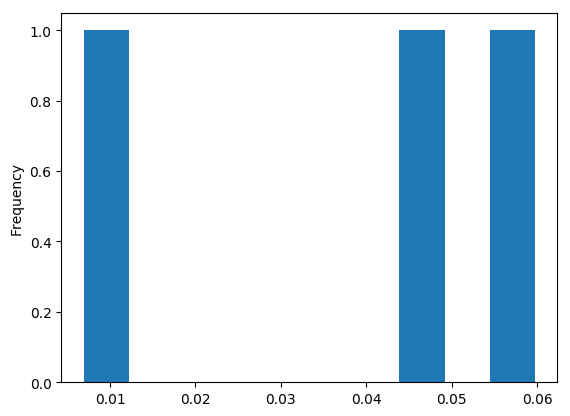

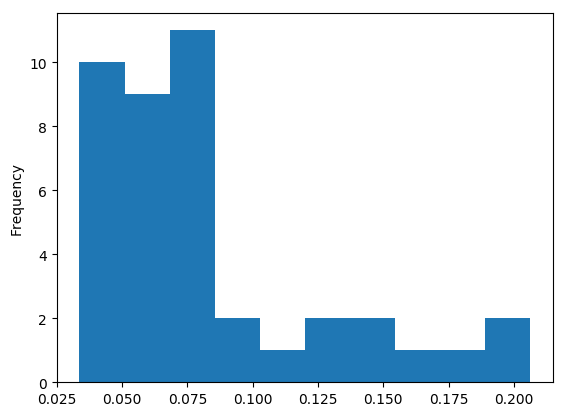

<Figure size 640x480 with 0 Axes>

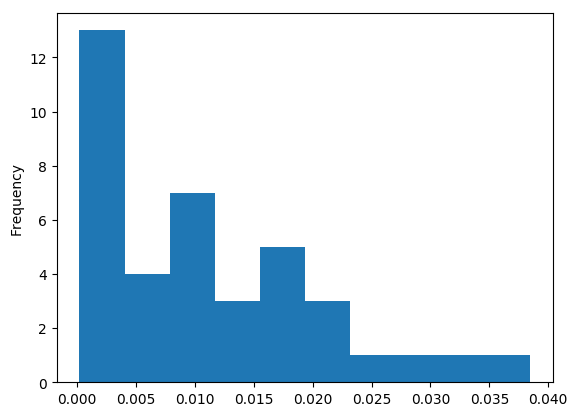

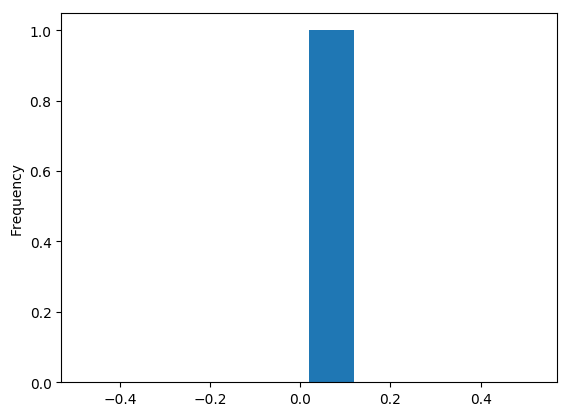

<Figure size 640x480 with 0 Axes>

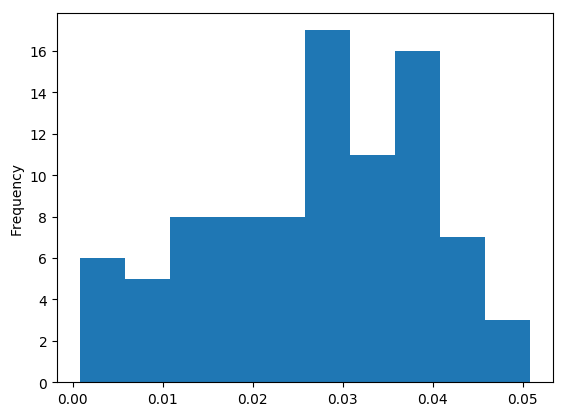

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

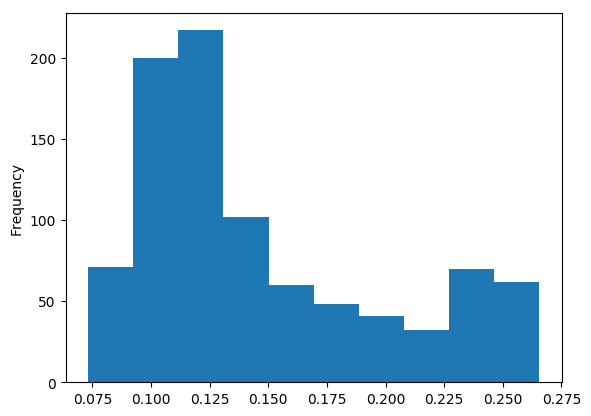

<Figure size 640x480 with 0 Axes>

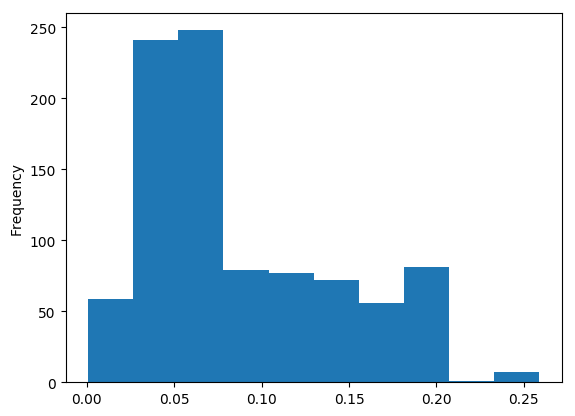

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [1562]:
for i in range(len(Data.groupby(by='Months').get_group(11))):
    delta = Data.groupby(by='Months').get_group(11).iloc[i][0:2016]-MyMeanTimeProb
    plt.figure()
    if len(delta[delta>0]):
        delta[delta>0].plot.hist()
        plt.show()
    else:
        pass

In [1530]:
delta = Data.groupby(by='Months').get_group(8).iloc[17][0:2016]-MyMeanTimeProb
len(delta[delta>0])

0

In [1545]:
Data.groupby(by='Months').get_group(12)['ObsLen'].sum()/3600

87.68956906389892

In [1555]:
a=0
for i in range(len(Data)):
    a += Data[i][1]/3600.

In [1556]:
a

1150.4244165682567